# Toy Model: Analysis

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle
import pandas as pd

# my preferred settings
mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 14)
mpl.rc('axes',labelsize = 16, linewidth=1.25)
mpl.rc('xtick',labelsize = 16)
mpl.rc('ytick',labelsize = 16)
# enable math fonts
mpl.rc('mathtext', default = 'regular')

from sbin.sbin import suppression_factor, suppression_simulation
from sbin import parameters

### Read in data saved from Filtering

In [2]:
with open("filtered_data.pkl", "rb") as f:
     data = pickle.load(f)
db_filtered = data["db_filtered"]
close = data["close"]
good = data["good"]
kois_filtered = data["kois_filtered"]
kois_good = data["kois_good"]
cks_filtered = data["cks_filtered"]

In [3]:
# separation values (as lists) for each star in binary sample
# for use in the simulation
tmp = db_filtered[good & close].groupby('KOI')['SepAU'].agg('unique')
binary_separations = np.concatenate(tmp.to_numpy())

# Toy Model

### Suppress the KOIs

In [4]:
# define bins for recording plotting
histrange=[0.5,4]
nbins=13

bin_edges = np.linspace(histrange[0], histrange[1], nbins + 1)
bin_width = bin_edges[1] - bin_edges[0]
bin_center = bin_edges[:-1] + bin_width/2.


# run trials and save the results
ntrials = 1000
koi_sim_hist = np.ones((ntrials,len(bin_center)))
koi_sim_npl = np.ones((ntrials,5))
frac_SE_arr = np.ones(ntrials)
mtps_arr = np.ones(ntrials)
for i in range(ntrials):
    prad_sim_tmp, sim_counts, frac_SE_arr[i], mtps_arr[i] = suppression_simulation(kois_filtered, 
                                                                              binary_separations,
                                                                              join_on='KOI', 
                                                                              prad_col='koi_prad')
    # histogram of planet radii
    hist, _ = np.histogram(prad_sim_tmp, 
            range=histrange, bins=nbins, density=True)
    koi_sim_hist[i] = hist
    

    # histogram of n_planets
    hist, _ = np.histogram(sim_counts['n_planets'], density=True, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
    koi_sim_npl[i] = hist
    

low, koi_prad_sim, high = np.percentile(koi_sim_hist, q=(2.25,50,98.75), axis=0)
e_koi_prad_sim = (high-low)/2

koi_SE_frac = np.percentile(frac_SE_arr, q=(2.25,13.6,50,86.4, 98.75))
print(koi_SE_frac)

#np.percentile(mtps_arr, q=(2.25,13.6,50,86.4, 98.75))

[0.45139327 0.45537341 0.46097111 0.46670815 0.47348485]


In [10]:
koi_MTPS_frac = np.percentile(mtps_arr, q=(2.25,13.6, 50,86.4,98.75))
print(koi_MTPS_frac)

[0.32023103 0.32858607 0.33726415 0.34675861 0.35545248]


###  Suppress CKS

In [5]:

cks_sim_hist = np.ones((ntrials,len(bin_center)))
cks_sim_npl = np.ones((ntrials,5))
for i in range(ntrials):
    prad_sim_tmp, sim_counts, frac_SE_arr[i], mtps_arr[i] = suppression_simulation(cks_filtered, binary_separations, join_on='KOI', prad_col='Rp')
    hist, _ = np.histogram(prad_sim_tmp, 
            range=histrange, bins=nbins, density=True)
    cks_sim_hist[i] = hist

    # histogram of n_planets
    hist, _ = np.histogram(sim_counts['n_planets'], density=True, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
    cks_sim_npl[i] = hist
    
    
low, cks_prad_sim, high = np.percentile(cks_sim_hist, q=(2.25,50,98.75), axis=0)
e_cks_prad_sim = (high-low)/2

cks_SE_frac = np.percentile(frac_SE_arr, q=(2.25,13.6, 50,86.4,98.75))

print(cks_SE_frac)

[0.55347385 0.5600316  0.5667466  0.5736246  0.579722  ]


In [9]:
cks_MTPS_frac = np.percentile(mtps_arr, q=(2.25,13.6, 50,86.4,98.75))
print(cks_MTPS_frac)

[0.32023103 0.32858607 0.33726415 0.34675861 0.35545248]


# Plot the results

### Radius

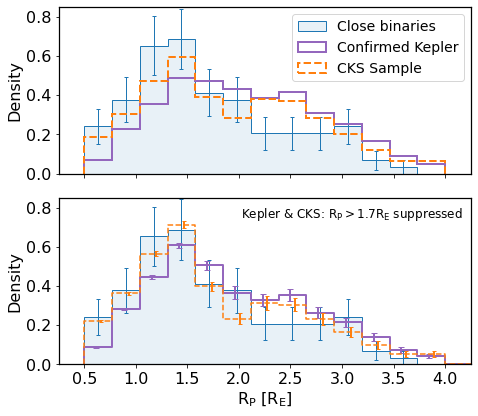

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=True, sharey=True)

# planets with good radii in binary systems with rho<100 au and planet period < 100 days
y, _, _ = axes[0].hist(db_filtered['Rppri'][good & close], 
             range=histrange, bins=nbins, density=True, 
         histtype='stepfilled', edgecolor='#1f77b4', facecolor='#e8f1f7',
        label='Close binaries')
n, _ = np.histogram(db_filtered['Rppri'][good & close], 
             range=histrange, bins=nbins)

axes[0].errorbar(bin_center, y, np.sqrt(n)/np.sum(n)/bin_width, ls='None', lw=1, capsize=2, c='C0')


# compared to the kois that are at least not definite binaries with good radii and per<100 days
axes[0].hist(kois_filtered['koi_prad'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label='Confirmed Kepler')

# compared to the cks
axes[0].hist(cks_filtered['Rp'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step',lw=2, linestyle='--', color='C1',
        label='CKS Sample')

axes[0].set_ylabel('Density')
axes[0].legend()

# planets with good radii in binary systems with rho<100 au and planet period < 100 days
axes[1].hist(db_filtered['Rppri'][good & close], 
             range=histrange, bins=nbins, density=True, 
             histtype='stepfilled',  edgecolor='#1f77b4', facecolor='#e8f1f7')
axes[1].errorbar(bin_center, y, np.sqrt(n)/np.sum(n)/bin_width, ls='None', lw=1, capsize=2, c='C0')


x = np.concatenate((bin_edges, [bin_edges[-1]+bin_width]))
y = np.concatenate(([0], koi_prad_sim, [0]))
plt.step(x, y, c='C4', lw=2)

y = np.concatenate(([0], cks_prad_sim, [0]))
plt.errorbar(bin_center-0.02, koi_prad_sim, e_koi_prad_sim, ls='None', lw=2, capsize=3, c='C4')
plt.step(x, y, linestyle='--', c='C1', lw=1.5)
plt.errorbar(bin_center+0.025, cks_prad_sim, e_cks_prad_sim, ls='None', lw=2, capsize=2, c='C1')

axes[1].text(0.98, 0.95, 'Kepler & CKS: $R_P>1.7 R_E$ suppressed',
     horizontalalignment='right',
     verticalalignment='top',
     fontsize=12,
     transform = axes[1].transAxes)

plt.xlim(0.25, 4.25)
plt.ylim(0,0.85)
plt.xlabel('$R_P$ [$R_E$]')
plt.ylabel('Density')
plt.tight_layout()
#plt.savefig('suppression.png')

### Multiplicity

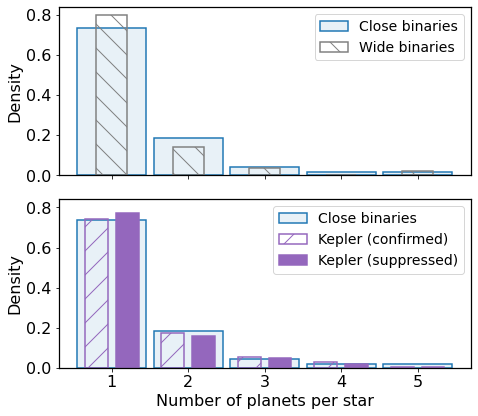

In [7]:
x = np.array([1,2,3,4,5])

close_planet_counts = db_filtered[close].groupby('KOI').size().reset_index(name='n_planets')
koi_planet_counts = kois_filtered.groupby('KOI').size().reset_index(name='n_planets')

#fig, axes = plt.subplots(1, 1, figsize=(7,5), sharex=True, sharey=True)
fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=True, sharey=True)

y, _ = np.histogram(close_planet_counts['n_planets'], density=True, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
axes[1].bar(x, y, edgecolor='#1f77b4', facecolor='#e8f1f7', width=0.9, lw=1.5, label='Close binaries')

y, _ = np.histogram(koi_planet_counts['n_planets'], density=True, bins=[0.5,1.5,2.5,3.5,4.5,5.5])     
axes[1].bar(x-0.2, y, edgecolor='C4', facecolor='None', hatch='/', width=0.3, lw=1.5, label='Kepler (confirmed)')

low, npl_sim, high = np.percentile(koi_sim_npl, q=(2.25,50,98.75), axis=0)
e_npl_sim = (high-low)/2

axes[1].bar(x+0.2, npl_sim, edgecolor='C4', facecolor='C4', width=0.3, lw=1.5, label='Kepler (suppressed)')
#plt.errorbar(, koi_prad_sim, e_koi_prad_sim, ls='None', lw=2, capsize=3, c='C4')

axes[1].legend()
axes[1].set_ylabel('Density')


y, _ = np.histogram(close_planet_counts['n_planets'], density=True, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
axes[0].bar(x, y, edgecolor='#1f77b4', facecolor='#e8f1f7', width=0.9, linewidth=1.5, label='Close binaries')

wide_planet_counts = db_filtered[~close].groupby('KOI').size().reset_index(name='n_planets')
y, _ = np.histogram(wide_planet_counts['n_planets'], density=True, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
axes[0].bar(x, y, edgecolor='gray', facecolor='None', hatch="\\", width=0.4, linewidth=1.5, label='Wide binaries')

axes[0].legend()
axes[0].set_ylabel('Density')
plt.xlabel('Number of planets per star')
plt.tight_layout()

#plt.savefig('multiplicity.png')